### **Set up the environment**

In [ ]:
#Enable plots to be displayed in the notebook
%matplotlib inline

# install and import libraries
!pip install seaborn

# Load data analysis and plotting packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string

# Load the nltk library and a pre-trained language model for English text
import nltk
from nltk.tokenize import word_tokenize
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk import BigramAssocMeasures
from nltk.text import Text  
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


# Load the spacy library and a pre-trained language model for English text
import spacy
nlp = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Import the data**

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the datasets
submissions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ANLP/AT2B/submissions.csv')

## **Remove PII**

In [ ]:
# Define a function that will loop over text and remove Proper Nouns
def spacy_ner(text):
    doc = nlp(text)
    deidentified_submissions = []
    for words in doc:
        if words.pos_ != 'PROPN':
            deidentified_submissions.append(words.text)
    return(' '.join(deidentified_submissions));

In [ ]:
# Apply the above function to the dataset
submissions['message_deidentified'] = submissions['Message'].apply(spacy_ner)

In [ ]:
submissions.sample(5)

,Location,Project,Message,Response,message_deidentified,message_clean,text_lemmatized
403,"LISMORE HEIGHTS , New South Wales",SSD-10418,The expansion of any coal mine in our current ...,Object,The expansion of any coal mine in our current ...,expansion current planetary climate crisis cri...,"[expansion, current, planetary, climate, crisi..."
338,"TOOWONG , Queensland",SSD-10418,I am an expat from Japanese power utility and ...,Support,I am an expat from Japanese power utility and ...,expat japanese power utility working rich land...,"[expat, japanese, power, utility, work, rich, ..."
612,"MARYS MOUNT , New South Wales",SSD-10269,"Being a local, I believe it will be great for ...",Support,"Being a local , I believe it will be great for...",local believe great region providing work inco...,"[local, believe, great, region, provide, work,..."
291,"GILLIESTON HEIGHTS , New South Wales",SSD-9349,I support this project as it provides a lot of...,Support,I support this project as it provides a lot of...,support provides lot opportunity employment ac...,"[support, provide, lot, opportunity, employmen..."
622,"EAST TAMWORTH , New South Wales",SSD-10269,"To ensure ongoing work for myself, my team and...",Support,"To ensure ongoing work for myself , my team an...",ensure ongoing work team local community provi...,"[ensure, ongoing, work, team, local, community..."


In [ ]:
# Remove new line indicator
submissions = submissions.replace(r'\n',' ', regex=True)
# Remove carriage indicator
submissions = submissions.replace(r'\r',' ', regex=True) 

In [ ]:
# Strip punctuation
submissions["message_clean"] = submissions["message_deidentified"].str.replace('[^\w\s]','')

<ipython-input-59-254f53b7d87e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  submissions["message_clean"] = submissions["message_deidentified"].str.replace('[^\w\s]','')


In [ ]:
# Strip numbers
submissions["message_clean"] = submissions["message_clean"].str. replace('\d+', '')

<ipython-input-61-651605517a30>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  submissions["message_clean"] = submissions["message_clean"].str. replace('\d+', '')


In [ ]:
# Convert to lowercase
submissions["message_clean"] = submissions["message_clean"].str.lower()

In [ ]:
# Remove stopwords
# Define stopwords
stop_words=stopwords.words("english")
stop_words.extend(['coal', 'mine', 'mining', 'mines', 'site', 'sites', 'operation', 'operations', 'project', 'projects', 'proposed', 'proposal', 'would', 'also', 'like'])
# Remove stopword
submissions['message_clean'] = submissions['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [ ]:
# The below function populates bar graph from a dataframe variable
def wordBarGraphFunction(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

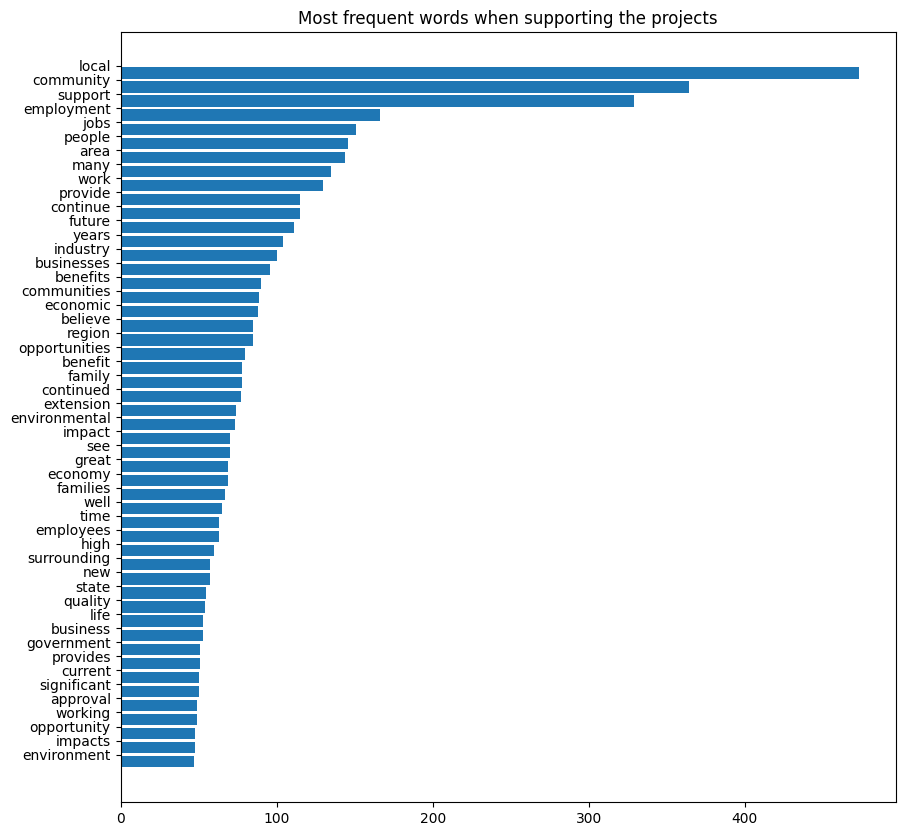

In [ ]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(submissions.loc[submissions['Response'] == 'Support'],'message_clean',"Most frequent words when supporting the projects")

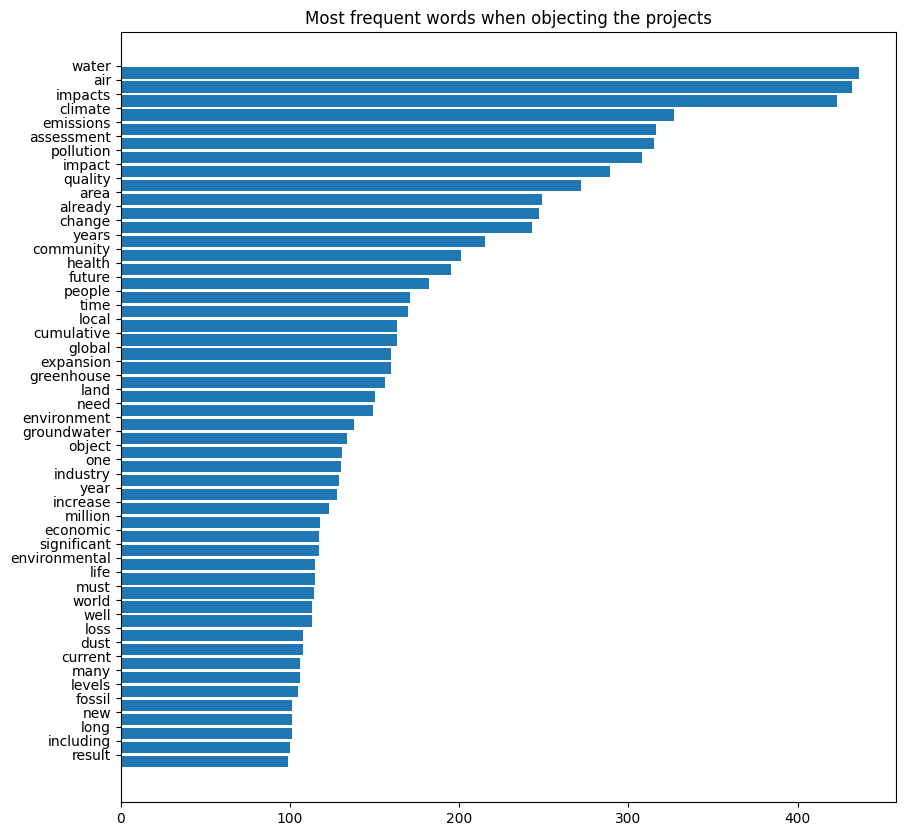

In [ ]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(submissions.loc[submissions['Response'] == 'Object'],'message_clean',"Most frequent words when objecting the projects")

In [ ]:
# Define a function that lemmatizes and tokenizes
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
    return [lemmatizer.lemmatize(w,'a') for w in w_tokenizer.tokenize(text)]
    return [lemmatizer.lemmatize(w,'n') for w in w_tokenizer.tokenize(text)]

In [ ]:
submissions['text_lemmatized'] = submissions['message_clean'].apply(lemmatize_text)

In [ ]:
## Split state out of location
new = submissions['Location'].str.split(',', 1, expand=True)
submissions['Location'] = new[0]
submissions['State'] = new[1]

## Clean fields ,remove "/n" at the beginning of state and end of location
submissions['State'] = submissions['State'].str[3:]
submissions['Location'] = submissions['Location'].str[:-1]

<ipython-input-40-7470c9be1615>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  new = submissions['Location'].str.split(',', 1, expand=True)


In [ ]:
## Count of messages by location
aggdf = submissions.groupby('Location')['Message'].agg('count')
aggdf = aggdf.to_frame()
aggdf['total'] = aggdf['Message'].agg('sum')
aggdf['percentage'] = aggdf['Message'] / aggdf['total'] * 100
aggdf['percentage'] = aggdf['percentage'].astype(int)

aggdf = aggdf.reset_index()
aggdf.sort_values(by='Message', ascending =False)

,Location,Message,total,percentage
187,MUSWELLBROOK,34,646,5
230,SCONE,28,646,4
195,NARRABRI,19,646,2
235,SINGLETON,18,646,2
122,GUNNEDAH,17,646,2
...,...,...,...,...
116,GRACEVILLE,1,646,0
117,GRAYS POINT,1,646,0
121,GUNDY,1,646,0
123,GWYNNEVILLE,1,646,0


In [ ]:
## Count of messages by State
aggdf = submissions.groupby('State')['Message'].agg('count')
aggdf = aggdf.to_frame()
aggdf['total'] = aggdf['Message'].agg('sum')
aggdf['percentage'] = aggdf['Message'] / aggdf['total'] * 100
aggdf['percentage'] = aggdf['percentage'].astype(int)

aggdf = aggdf.reset_index()
aggdf.sort_values(by='Message', ascending =False)

,State,Message,total,percentage
2,New South Wales,616,646,95
4,Queensland,18,646,2
1,Australian Capital Territory,5,646,0
5,Victoria,3,646,0
0,,2,646,0
3,Northern Territory,1,646,0
6,Western Australia,1,646,0


In [ ]:
submissions.sample(10)

,Location,Project,Message,Response,message_deidentified,message_clean,text_lemmatized,State
597,FISHING POINT,SSD-10269,it will continue to provide employment for hun...,Support,it will continue to provide employment for hun...,continue provide employment hundreds people,"[continue, provide, employment, hundreds, people]",New South Wales
441,MUDGEE,SSD-10418,"It is outrageous, that in the face of our know...",Object,"It is outrageous , that in the face of our kno...",outrageous face knowledge burning last thing c...,"[outrageous, face, knowledge, burn, last, thin...",New South Wales
130,SINGLETON,SSD-9349,I would like to submit a letter in support of ...,Support,I would like to submit a letter in support of ...,submit letter support continued near name empl...,"[submit, letter, support, continue, near, name...",New South Wales
456,Aberdeen,SSD-10418,I object to the Mount Pleasant Optimisation pr...,Object,I object to the proposal and seek that an r...,object seek reviews proponent technical report...,"[object, seek, review, proponent, technical, r...",New South Wales
437,SEAHAM,SSD-10418,Good for the local economy.,Support,Good for the local economy .,good local economy,"[good, local, economy]",New South Wales
317,Bolwarra,SSD-9349,I have been apart of the mining industry since...,Support,I have been apart of the mining industry since...,apart industry since provided great opportunit...,"[apart, industry, since, provide, great, oppor...",New South Wales
41,CHARLESTOWN,SSD-9349,Do it,Support,Do it,,[],New South Wales
548,MIDDLE BROOK,SSD-10418,I would like to object in the strongest possib...,Object,I would like to object in the strongest possib...,object strongest possible terms years lived ru...,"[object, strongest, possible, term, years, liv...",New South Wales
309,SINGLETON HEIGHTS,SSD-9349,I am for the GCOP. Unlike some of the people ...,Support,I am for the . Unlike some of the people obj...,unlike people objecting know tight knit enviro...,"[unlike, people, object, know, tight, knit, en...",New South Wales
8,STANHOPE,SSD-9349,I am an employee at Glendell mine. The mine su...,Support,I am an employee at mine . The mine supports m...,employee supports family children live support...,"[employee, support, family, children, live, su...",New South Wales


In [ ]:
# Create a function that converts text to string
def to_string(text):
    text = ' '.join(map(str, text))
    return text

# Convert the clean text list to string
submissions['text_clean_lemma'] = list(map(to_string, submissions['text_lemmatized']))

In [ ]:
submissions.sample(10)

,Location,Project,Message,Response,message_deidentified,message_clean,text_lemmatized,State,text_clean_lemma
138,BISHOPS BRIDGE,SSD-9349,"To whom it may concern; I Brendan Mudd, wish...",Support,"To whom it may concern ; I , wish to submi...",may concern wish submit application support lo...,"[may, concern, wish, submit, application, supp...",New South Wales,may concern wish submit application support lo...
344,Perth,SSD-10418,This project and its approval to continue unti...,Support,This project and its approval to continue unti...,approval continue absolutely critical communit...,"[approval, continue, absolutely, critical, com...",Western Australia,approval continue absolutely critical communit...
26,RUTHERFORD,SSD-9349,"Mining is important to my family, community an...",Support,"Mining is important to my family , community a...",important family community fully support conti...,"[important, family, community, fully, support,...",New South Wales,important family community fully support conti...
168,MACKSVILLE,SSD-9349,I support this project as they are a major emp...,Support,I support this project as they are a major emp...,support major employer hunter valley support l...,"[support, major, employer, hunter, valley, sup...",New South Wales,support major employer hunter valley support l...
62,RUTHERFORD,SSD-9349,I have worked in the mining industry for over ...,Support,I have worked in the mining industry for over ...,worked industry years last years contractor pe...,"[work, industry, years, last, years, contracto...",New South Wales,work industry years last years contractor perm...
132,GOWRIE,SSD-9349,The project will give jobs to people in the hu...,Support,The project will give jobs to people in the hu...,give jobs people hunter surrounds direct work ...,"[give, job, people, hunter, surround, direct, ...",New South Wales,give job people hunter surround direct work lo...
293,ELERMORE VALE,SSD-9349,We don’t need any more air pollution than we a...,Object,We do n’t need any more air pollution than we ...,nt need air pollution already right,"[nt, need, air, pollution, already, right]",New South Wales,nt need air pollution already right
612,MARYS MOUNT,SSD-10269,"Being a local, I believe it will be great for ...",Support,"Being a local , I believe it will be great for...",local believe great region providing work inco...,"[local, believe, great, region, provide, work,...",New South Wales,local believe great region provide work income...
6,FERN BAY,SSD-9349,I support the Glendell extension whole hearted...,Support,I support the extension whole heartedly . I am...,support extension whole heartedly resident hun...,"[support, extension, whole, heartedly, residen...",New South Wales,support extension whole heartedly resident hun...
483,NORTH ROTHBURY,SSD-10418,I support the extension of the project as my l...,Support,I support the extension of the project as my l...,support extension livelihood well countless ot...,"[support, extension, livelihood, well, countle...",New South Wales,support extension livelihood well countless ot...


In [ ]:
submissions.to_csv('/content/drive/MyDrive/Colab Notebooks/ANLP/AT2B/submissions clean.csv', index=False)